# Module: RDF

This module contains functions for calculating radial distribution functions from a series of diffraction images obtained in 4D-STEM mode from a FEM experiment. The process follows closely along the procedure described in Ref. [1]. The data presented in this notebook are from a cell of amorphous Tantalum, simulated with molecular dynamics. The 4D-STEM images are taken from a Prismatic simulation, with a semiangle of 0.51 mrad and accelerating voltage of 200 kV for a 6nm thick sample.

### Procedure Outline

1) Load data and perform necessary preprocessing

2) Get polar transform of diffraction series and correct for any elliptical distortions

3) Generate a radial intensity profile and get a corresponding diffraction space coordinate vector

4) Calculate and fit the single atom scattering factor to the tails of the radial intensity profile (see Ref [2]).

5) Calculate the structure factors $\phi(q)$ and applying any masking/zero padding

6) Perform a discrete sine transform to obtain the radial distribution functions g(r).

#### References

[1] Cockayne, Annu. Rev. Mater. Res. 37:15987 (2007)

[2] Lobato et. al, Acta Cryst. (2014). A70, 636–649.

### Import packages, load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
import scipy.io as sio
from py4DSTEM.process import rdf
from py4DSTEM.process.utils import print_progress_bar
from py4DSTEM.process.utils import polar_elliptical_transform

In [2]:
# Get data and masks
fp = "/media/lerandc/DATA/files/Amorphous_simulations/Ta_cell/Ta_sim_sa_051_highQ.h5"
browser = py4DSTEM.file.io.FileBrowser(fp)
datacube = browser.get_dataobject('CBED_array_depth0000')

### 1 and 2) Preprocessing and polar corrections

See the demonstration notebook on the polar-elliptical transform for more details on how the polar transformation works. In the following cells, the data are loaded and a polar transforamtion is calculated for the series of diffraction images.

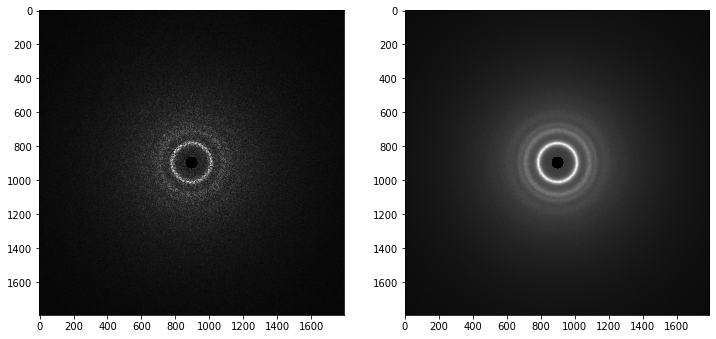

In [3]:
cubeShape = datacube.data.shape

#calculate radial coordinate system
yy,xx = np.meshgrid(np.arange(cubeShape[2]),np.arange(cubeShape[3]))
yy = yy - cubeShape[2]//2
xx = xx - cubeShape[3]//2
rr = np.sqrt(xx**2+yy**2)

#create center beam mask and polar transform fitting mask
mask = rr > 35
fit_mask = np.logical_and(rr> 50, rr < 175)

#calculate mean diffraction image
CBEDmean = np.mean(datacube.data,axis=(0,1))
fig,(ax11,ax12) = plt.subplots(1,2,figsize=(12,12))
ax11.imshow(mask*datacube.data[0,0,:,:]**0.4)
ax12.imshow(mask*CBEDmean**0.4)

In [4]:
# Get initial polar transform
### Params ###
x0_init=None
y0_init=None
dr= 1             # in pixels
dtheta= 2.5       # in degrees
r_range= 900      # either [min,max] or just max --> [0,max]
##############

# Perform transform
pet = polar_elliptical_transform(calibration_image=CBEDmean,
                                 mask=fit_mask,
                                 x0_init=x0_init,
                                 y0_init=y0_init,
                                 dr=dr,
                                 dtheta=dtheta,
                                 r_range=r_range)
transform_mask = rr > 30
pet.get_polar_transform(mask=transform_mask)

In [5]:
# Fit all coefficients

#### Params ####
n_iter=50
step_sizes_init = [0.1, 0.1, 0, 0.1, 0.1]    # Initial step sizes for [x0,y0,A,B,C] 
step_scale=0.9                               # If no step is taken, reduce step sizes by this fraction
################

# Perform fit
scores,x_vals,y_vals,A_vals,B_vals,C_vals = pet.fit_params(n_iter=n_iter,
                                                           step_sizes_init=step_sizes_init,
                                                           step_scale=step_scale,
                                                           return_ans=True)

Analyzing: |**************************************************| 100.0% Complete



### 2b) Further processing

Prismatic provides simulated results in fractional intensity per pixel. In order to more closely mimic experimental data, Poisson noise was applied with an arbitrary scaling factor. After the application of Poisson noise to each individual image, a new polar image is calculated from the resultant noisy mean CBED pattern using the previously fitted polar transform.

Experimental data should at the least have the background intensity profile subtracted from the diffraction images. Not doing so cause problematic fitting of the single atom scattering and results in inaccurate calculations of the structure factors $\phi(q)$.

In [6]:
def addPoissonNoise(orig,scale):
    #applies poisson noise after first scaling image array from [0,x] to [0,scale]
    #orig is noiseless image matrix, scale is scaling factor to assign discrete probablities of electron counts
    #returns noisy image array
    if scale > 0.0:
        scale /= np.max(orig)
        orig = orig*scale
        noisy = np.random.poisson(orig)
        return noisy
    return orig

In [7]:
#polar CBED mean is the calibration image currently
polarCBEDmean = pet.polar_ar
CBED_stack = np.reshape(datacube.data,(cubeShape[0]*cubeShape[1],cubeShape[2],cubeShape[3]))
CBED_stack_noisy = np.copy(CBED_stack)

#apply poisson noise
epx = 150
for i in range(CBED_stack_noisy.shape[0]):
    CBED_stack_noisy[i,:,:] = addPoissonNoise(transform_mask*CBED_stack[i,:,:],epx)
    
CBEDmean_noisy = np.mean(CBED_stack_noisy,axis=0)
polarCBEDmean_noisy, __ = pet.get_polar_transform(ar=CBEDmean_noisy,mask=np.ones(CBEDmean_noisy.shape),return_ans=True)

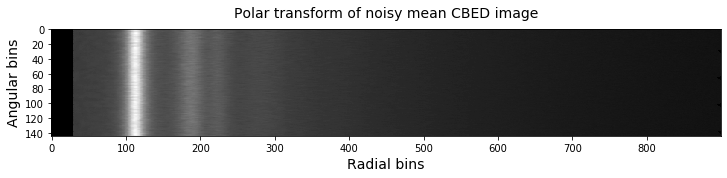

In [8]:
#plotting
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.matshow(polarCBEDmean_noisy**0.4)
ax.set_xlabel('Radial bins',fontsize=14)
ax.set_ylabel('Angular bins',fontsize=14)
ax.set_title('Polar transform of noisy mean CBED image',fontsize=14)
ax.xaxis.set_ticks_position('bottom')

### 3) Getting radial intensity profile and diffraction space array

The radial intensity profile $I(q)$ is calculated by taking the average along $\theta$ of the polar transform. Depending on the binning used and the experiental calibration, values for $dq$, the diffraction pixel size, may vary. Since simulated data are presented, the $dq$ is calculated directly from known values.

The get_radial_intensity() function has the following parameters:

    polar_img: the CBED pattern used to calculate a radial intensity profile
    polar_mask: a mask which is used to normalize the radial intensity profile post-binning
    
get_radial_intensity() has one output, which is $I(q)$

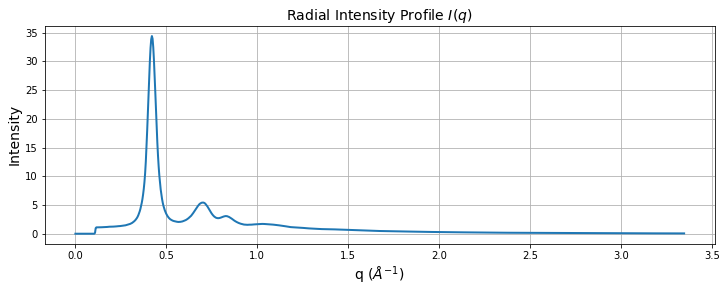

In [9]:
I_q = rdf.get_radial_intensity(polarCBEDmean_noisy,pet.polar_mask)

pixelSize = 0.074945675223214          #real space pixel size in Prismatic simulation
dq = 1/(2*CBEDmean.shape[0]*pixelSize) #2 times image shape due to antialiasing mask in prismatic
q_arr = np.arange(I_q.shape[0])*dq

# plotting
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(q_arr,I_q,linewidth=2)
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax.set_ylabel('Intensity',fontsize=14)
ax.set_title('Radial Intensity Profile $I(q)$',fontsize=14)
ax.grid()

### 4) Calculating the single atom scattering factor and fitting

Here, the single atom scattering factor $f^2(q)$ is calculated using the parameterization provided in Ref. [2]. $I(q)$ in this case is compared to $Nf^2(q)$. Currently, there is no automatic fitting scheme to calculate $N$. One should aim to fit the  tail of the intensity profile to the tail of the single atom scattering factor, as only at high scattering angles will $I(q)$ and $Nf^2(q)$ be in agreement.

The fit_scattering_factor() function has the following parameters:
    
    scale: linear factor N
    elements: 1D list of atomic numbers (integers)
    composition: 1D list of atomic fractions or stoichiometry of material
    q_arr: 1D diffraction space vector
    units: 'A' or 'VA' for returning the scattering factor in units of angstroms or volt angstroms
    
fit_scattering_factor() has one output, which is $Nf^2(q)$

(0, 0.5)

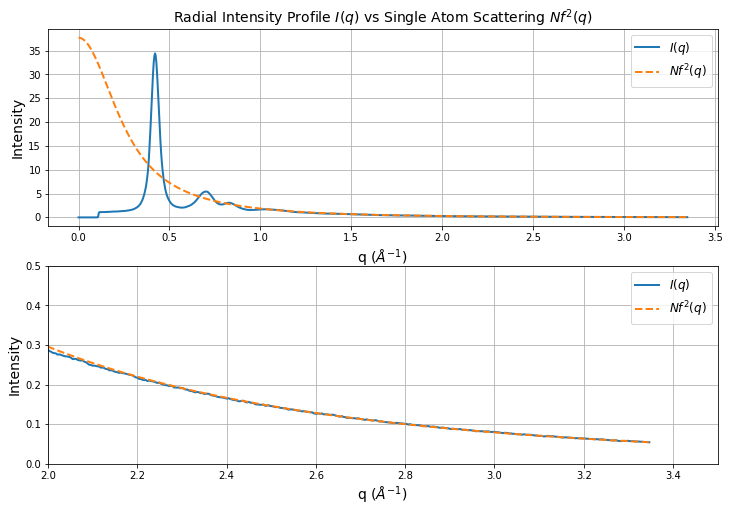

In [14]:
scale = 0.225     #N in N*f(q)^2
elements = [73]   #list of atomic numbers (even if just 1)
                  #e.g, for Gd2Ti2O7, [64,22,8]
composition = [1] #list of atomic fractions or stoichiometry (even if just 1)
                  #e.g., for Gd2Ti2O7, either [2/9, 2/9, 7/9] or [2, 2, 7]
scatter = rdf.fit_scattering_factor(scale,elements,composition,q_arr,'A')

# plotting
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
ax1.plot(q_arr,I_q,linewidth=2,label='$I(q)$')
ax1.plot(q_arr,scatter,linestyle='--',linewidth=2, label='$Nf^2(q)$')
ax1.grid()
ax1.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax1.set_ylabel('Intensity',fontsize=14)
ax1.set_title('Radial Intensity Profile $I(q)$ vs Single Atom Scattering $Nf^2(q)$',fontsize=14)
ax1.legend(fontsize=12)

ax2.plot(q_arr,I_q,linewidth=2,label='$I(q)$')
ax2.plot(q_arr,scatter,linestyle='--',linewidth=2, label='$Nf^2(q)$')
ax2.grid()
ax2.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax2.set_ylabel('Intensity',fontsize=14)
ax2.legend(fontsize=12)
ax2.set_xlim(2,3.5)
ax2.set_ylim(0,.5)

### 5a) Calculating the structure factors

Once the the single atom scattering factors are fit, we can calculate the structure factors $\phi(q)$ through the following relation:

$$\phi(q) = \Bigg [ \frac{I(q) - Nf^2(q)}{Nf^2(q)} \Bigg ] q$$

Here, it should be more clear whether or not the fit of the single atom scattering factor was good enough. $\phi(q)$ should oscillate about the zero axis, and should decay toward zero at high $q$. If $N$ is too large, the high angle tail of $\phi(q)$ will have a negative slope, and if $N$ is too small, it will have a positive slope. 

The get_phi() function has the following parameters:

    radialIntensity: radial intensity profile I(q)
    scatter: single atom scattering factor N*f^2(q)
    q_arr: 1D diffraction space vector
    
get_phi() has one output, which is $\phi(q)$

Text(0.5, 1.0, 'Structure Factors $\\phi(q)$')

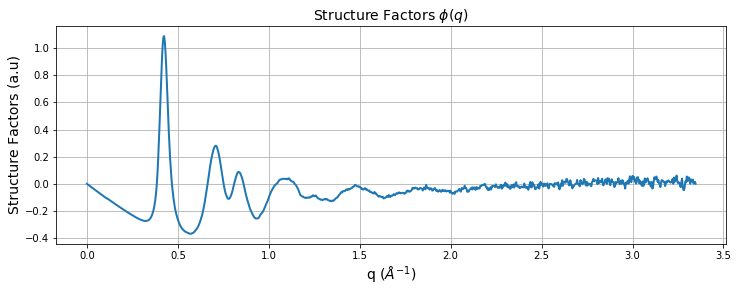

In [15]:
phi = rdf.get_phi(I_q,scatter,q_arr)

#plotting
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(q_arr,phi,linewidth=2)
ax.grid()
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax.set_ylabel('Structure Factors (a.u)',fontsize=14)
ax.set_title('Structure Factors $\phi(q)$',fontsize=14)

### 5b) Masking of the signal

To prevent artifacts at high and low frequencies due to the center beam and the cut off, it can be helpful to include a masking window for the structure factors $\phi(q)$. The mask is monotonically increasing on the left side, and monotonically decereasing on the right side.

The get_mask() function has the following parameters:

    left: midpoint of increasing erf (mask = 0.5 at left) (in units of q) 
    right: midpoint of decreasing erf (mask = 0.5 at right) (in units of q)     
    midpoint: point in q space where mask sides are stitched     
    slopes: relative scale of decay    
    q_arr: 1D diffraction space vector 
    
get_mask() has one output, which is the mask generated by the above parameters

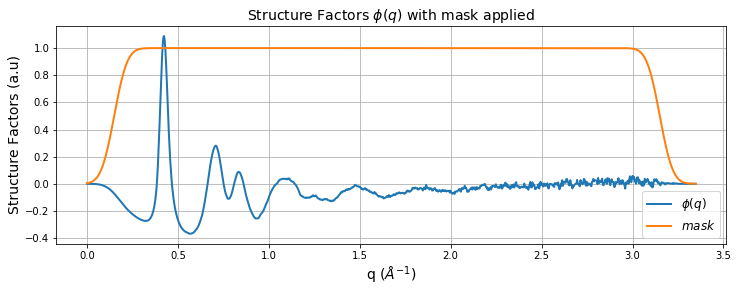

In [16]:
left = 0.15
right = 3.15
midpoint = 1.5
slopes = [12.5,12.5]
phi_mask = rdf.get_mask(left,right,midpoint,slopes,q_arr)

#plotting
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(q_arr,phi*phi_mask,linewidth=2, label='$\phi(q)$')
ax.plot(q_arr,phi_mask,linewidth=2, label='$mask$')
ax.grid()
ax.set_xlabel('q ($\AA^{-1}$)',fontsize=14)
ax.set_ylabel('Structure Factors (a.u)',fontsize=14)
ax.set_title('Structure Factors $\phi(q)$ with mask applied',fontsize=14)
ax.legend(fontsize=12)

### 6) Calculate the radial distribution function
Once the structure factors have been calculated, we are now ready to compute the radial distribution function. The radial distribution function is calculated with a discrete sine transform, approximating the following relation [1]

$$ G(r) = \int_0^\infty \phi(q)\sin(qr) dr  = 4\pi r \big [ g(r) - \rho_0 \big]$$

where $G(r)$ is the reduced pair distribution function, $g(r)$ is the radial distribution function, and $\rho_0$ is the bulk number density of atoms. In the current implementation, $\rho_0$ is not accounted for in extracting $g(r)$. The discrete sine transforms are computed with those provided in Scipy's FFT pack. Here, we use forward discrete sine transform, type 2, as it was found to be the most stable and accurate in our testing, though mileage may vary. Scaling factors are accounted for in the current implementation. 

The function get_rdf() takes in the following parameters:

    phi: the structure factors (masked or unmasked)
    q_arr: 1D diffraction space vector
    
get_rdf() has two outputs:

    g_r: the radial distribution function
    radius: the real space values at which g_r is computed
    
The output resolution of $g(r)$ is directly dependent on the extent of the radial intensity profile $I(q)$ in diffraction space, and can be calculated as

$$dr = \frac{1}{2q_{max}}  $$

where $dr$ is the real space resolution and $q_{max}$ is the maximum scattering angle included. Signal features closer apart in real space $dr$ cannot be reliably distinguished through discrete fourier transforms wihtout meausring out to higher scattering angles, no matter the noise reduction or masking applied. Zero-padding $\phi(q)$ can help place detectable features in $g(r)$ at more precise radial measurements, however, it still will not help in distinguishing features closer together than $dr$.

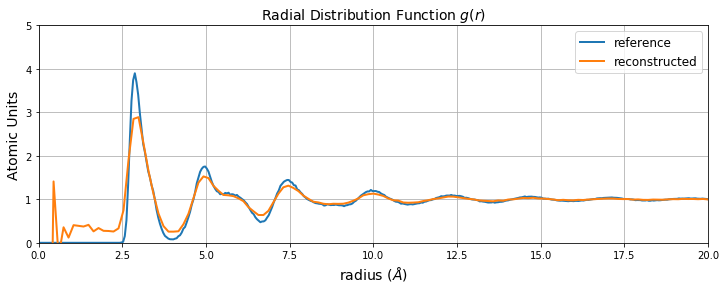

In [17]:
g_r,radius = rdf.get_rdf(phi*phi_mask,q_arr)

#reference data directly from atomic model
ref_rad = sio.loadmat('/home/lerandc/Ta_rad.mat')
ref_g_r = sio.loadmat('/home/lerandc/Ta_g_r.mat')
ref_rad = ref_rad['rad']
ref_g_r = ref_g_r['g_r']

#plotting
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ref_rad,ref_g_r,linewidth=2,label='reference')
ax.plot(radius,g_r,linewidth=2,label='reconstructed')
ax.grid()
ax.set_xlabel('radius ($\AA$)',fontsize=14)
ax.set_ylabel('Atomic Units',fontsize=14)
ax.set_title('Radial Distribution Function $g(r)$',fontsize=14)
ax.set_xlim(0,20)
ax.set_ylim(0,5)
ax.legend(fontsize=12)